# Principal Component Analysis As A Factor Model

## Introduction
...**To Do**

Import packages

In [1]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt

Magic

In [2]:
%matplotlib inline

## Data Collection

Set keys

In [3]:
keys = ['sp500',
        'sp400',
        'sp600']

Initialize S&P Indices close data

In [4]:
close = {}

Update S&P Indices close data

In [5]:
for i in keys: 
    # Load OHLCV data
    with open(i + '_data.pickle', 'rb') as f:
        data = pickle.load(f)
    
    # Update close prices data
    close[i] = data.close.loc['2014-06-12':]
    
    # Close file
    f.close

Inspect S&P 500 index constituents data

In [6]:
close['sp500'].head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-12,39.7726,38.2958,123.2252,84.5860,44.6031,65.9975,23.03,35.7925,74.5018,66.56,...,25.8547,41.1019,83.8928,46.4230,28.5372,35.2780,51.2950,101.0367,27.7535,30.8448
2014-06-13,39.8407,38.4672,123.7407,83.6603,45.0187,66.2930,22.95,35.7745,74.7820,66.82,...,25.8884,41.6091,84.7098,46.3744,28.4920,36.0532,51.5945,101.2861,27.8192,30.9702
2014-06-16,39.7181,39.1150,124.0086,84.5035,44.8857,66.0529,23.27,35.8734,74.8634,67.62,...,26.0740,41.9028,84.9326,46.4424,28.3791,35.9318,51.5099,100.7105,27.4060,30.9798
2014-06-17,40.0927,39.8867,124.9411,84.3935,45.1351,66.2561,23.43,35.8375,74.5832,67.54,...,26.0910,42.2409,84.5200,46.2677,28.8310,36.0346,51.7639,100.4707,27.9601,31.6355
2014-06-18,40.3651,40.6392,128.6809,84.4852,45.3595,66.5886,23.37,36.2960,74.7459,73.08,...,26.7810,42.1964,84.7758,46.3841,28.7406,36.3521,51.8876,101.7178,27.9977,31.7126


Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-12,39.7726,38.2958,123.2252,84.5860,44.6031,65.9975,23.03,35.7925,74.5018,66.56,...,25.8547,41.1019,83.8928,46.4230,28.5372,35.2780,51.2950,101.0367,27.7535,30.8448
2014-06-13,39.8407,38.4672,123.7407,83.6603,45.0187,66.2930,22.95,35.7745,74.7820,66.82,...,25.8884,41.6091,84.7098,46.3744,28.4920,36.0532,51.5945,101.2861,27.8192,30.9702
2014-06-16,39.7181,39.1150,124.0086,84.5035,44.8857,66.0529,23.27,35.8734,74.8634,67.62,...,26.0740,41.9028,84.9326,46.4424,28.3791,35.9318,51.5099,100.7105,27.4060,30.9798
2014-06-17,40.0927,39.8867,124.9411,84.3935,45.1351,66.2561,23.43,35.8375,74.5832,67.54,...,26.0910,42.2409,84.5200,46.2677,28.8310,36.0346,51.7639,100.4707,27.9601,31.6355
2014-06-18,40.3651,40.6392,128.6809,84.4852,45.3595,66.5886,23.37,36.2960,74.7459,73.08,...,26.7810,42.1964,84.7758,46.3841,28.7406,36.3521,51.8876,101.7178,27.9977,31.7126


In [7]:
close['sp500'].tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,67.95,29.12,154.61,179.64,76.75,82.21,267.06,77.46,177.97,268.71,...,57.78,106.90,73.59,54.40,33.30,77.40,106.97,117.41,44.40,108.12
2019-06-05,68.35,30.36,154.61,182.54,77.06,81.65,268.80,78.69,179.56,272.86,...,59.32,105.60,72.98,55.38,33.42,78.88,107.29,118.54,44.18,108.50
2019-06-06,69.16,30.38,154.90,185.22,77.07,81.75,269.19,80.09,180.40,274.80,...,59.80,106.01,74.31,55.63,34.03,79.15,108.42,120.31,44.24,108.89
2019-06-07,69.52,30.92,155.35,190.15,77.43,83.48,267.87,80.74,182.92,278.16,...,59.43,107.49,74.58,55.94,34.16,79.56,109.07,120.73,43.64,110.06
2019-06-10,70.29,30.76,153.52,192.58,76.95,84.77,272.43,81.27,184.44,280.34,...,59.26,110.88,74.91,57.10,34.69,80.38,108.65,121.71,43.84,110.22


Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,67.95,29.12,154.61,179.64,76.75,82.21,267.06,77.46,177.97,268.71,...,57.78,106.90,73.59,54.40,33.30,77.40,106.97,117.41,44.40,108.12
2019-06-05,68.35,30.36,154.61,182.54,77.06,81.65,268.80,78.69,179.56,272.86,...,59.32,105.60,72.98,55.38,33.42,78.88,107.29,118.54,44.18,108.50
2019-06-06,69.16,30.38,154.90,185.22,77.07,81.75,269.19,80.09,180.40,274.80,...,59.80,106.01,74.31,55.63,34.03,79.15,108.42,120.31,44.24,108.89
2019-06-07,69.52,30.92,155.35,190.15,77.43,83.48,267.87,80.74,182.92,278.16,...,59.43,107.49,74.58,55.94,34.16,79.56,109.07,120.73,43.64,110.06
2019-06-10,70.29,30.76,153.52,192.58,76.95,84.77,272.43,81.27,184.44,280.34,...,59.26,110.88,74.91,57.10,34.69,80.38,108.65,121.71,43.84,110.22


In [8]:
close['sp500'].describe()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,...,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.00000,1257.000000,1257.000000
mean,52.020384,41.208459,145.434801,135.133436,66.670458,84.568308,162.852343,49.123858,118.508010,142.302737,...,39.362328,58.865112,75.435801,53.179431,26.876008,51.309177,66.614527,111.70591,36.711273,59.821177
std,13.868035,6.368716,24.131106,38.117633,17.717831,9.473348,116.557311,12.652720,31.178171,70.409857,...,8.317325,22.243159,4.713198,7.834761,3.222998,16.350151,15.998532,9.92955,10.738373,20.214756
min,32.258600,24.539800,79.168700,82.743800,42.066600,65.718100,22.220000,33.935700,68.852300,60.880000,...,25.247700,32.502600,58.967500,34.178400,18.532600,28.874500,44.181800,89.23610,18.885300,30.652000
25%,39.391500,36.574400,132.526400,103.637500,53.175300,77.745400,80.700000,39.410700,92.630500,82.100000,...,31.489100,42.116300,72.522500,48.734500,24.214700,35.032500,53.061000,103.35200,26.823800,44.771300
50%,46.123400,40.847900,150.479700,119.476200,58.475100,83.862300,118.580000,43.045400,112.149800,107.970000,...,39.059500,52.731200,75.815100,54.533600,26.571900,48.112000,61.584700,112.77000,38.252800,51.338500
75%,65.603800,46.127100,161.921100,167.857700,82.898700,89.855500,261.940000,58.174900,149.608800,212.280000,...,45.463000,68.820200,78.488900,59.653000,29.655300,67.341800,80.207700,119.13230,46.435300,80.866200
max,81.940000,57.586600,199.159900,229.392000,116.445400,107.649700,449.750000,81.270000,184.440000,289.250000,...,59.800000,139.263300,86.137400,67.795300,35.000000,83.549000,109.070000,130.91280,57.139500,110.220000


Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,...,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.00000,1257.000000,1257.000000
mean,52.020384,41.208459,145.434801,135.133436,66.670458,84.568308,162.852343,49.123858,118.508010,142.302737,...,39.362328,58.865112,75.435801,53.179431,26.876008,51.309177,66.614527,111.70591,36.711273,59.821177
std,13.868035,6.368716,24.131106,38.117633,17.717831,9.473348,116.557311,12.652720,31.178171,70.409857,...,8.317325,22.243159,4.713198,7.834761,3.222998,16.350151,15.998532,9.92955,10.738373,20.214756
min,32.258600,24.539800,79.168700,82.743800,42.066600,65.718100,22.220000,33.935700,68.852300,60.880000,...,25.247700,32.502600,58.967500,34.178400,18.532600,28.874500,44.181800,89.23610,18.885300,30.652000
25%,39.391500,36.574400,132.526400,103.637500,53.175300,77.745400,80.700000,39.410700,92.630500,82.100000,...,31.489100,42.116300,72.522500,48.734500,24.214700,35.032500,53.061000,103.35200,26.823800,44.771300
50%,46.123400,40.847900,150.479700,119.476200,58.475100,83.862300,118.580000,43.045400,112.149800,107.970000,...,39.059500,52.731200,75.815100,54.533600,26.571900,48.112000,61.584700,112.77000,38.252800,51.338500
75%,65.603800,46.127100,161.921100,167.857700,82.898700,89.855500,261.940000,58.174900,149.608800,212.280000,...,45.463000,68.820200,78.488900,59.653000,29.655300,67.341800,80.207700,119.13230,46.435300,80.866200
max,81.940000,57.586600,199.159900,229.392000,116.445400,107.649700,449.750000,81.270000,184.440000,289.250000,...,59.800000,139.263300,86.137400,67.795300,35.000000,83.549000,109.070000,130.91280,57.139500,110.220000


In [9]:
close['sp500'].shape

(1257, 505)

(1257, 505)

Drop tickers with NaNs greater than 20

In [10]:
for i in keys:
    # Tickers with NaNs
    mask = (sum([close[i].isna()]).sum(axis='rows')!=0)
    tickers_na = close[i].columns[mask]
    
    # Drop tickers with NaNs less than 20
    for j in tickers_na:
        count_na = sum(close[i][j].isna())
        #
        if count_na > 20:
            pass
        else:
            tickers_na = tickers_na.drop(j)
            
    # Update close prices 
    close[i] = close[i].drop(columns=tickers_na)

Fill NaNs with previous observation

In [11]:
close['sp500'].fillna(method='ffill', inplace=True)

In [12]:
close['sp400'].fillna(method='ffill', inplace=True)

In [13]:
close['sp600'].fillna(method='ffill', inplace=True)

Count the number of NaNs per S&P Index

In [14]:
sum([close['sp500'].isna()]).sum(axis='columns').sum('rows')

5.0

5.0

In [15]:
sum([close['sp400'].isna()]).sum(axis='columns').sum('rows')

0.0

0.0

In [16]:
sum([close['sp600'].isna()]).sum(axis='columns').sum('rows')

24.0

24.0

Initialize daily returns

In [17]:
returns = {}

Calculate daily returns

In [18]:
for i in keys:
    # Update returns 
    returns[i] = close[i].pct_change()

Inspect S&P 500 Index constituents' returns

In [19]:
returns['sp500'].head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-13,0.001712,0.004476,0.004183,-0.010944,0.009318,0.004477,-0.003474,-0.000503,0.003761,0.003906,...,0.001303,0.012340,0.009739,-0.001047,-0.001584,0.021974,0.005839,0.002468,0.002367,0.004066
2014-06-16,-0.003077,0.016840,0.002165,0.010079,-0.002954,-0.003622,0.013943,0.002765,0.001088,0.011972,...,0.007169,0.007059,0.002630,0.001466,-0.003963,-0.003367,-0.001640,-0.005683,-0.014853,0.000310
2014-06-17,0.009431,0.019729,0.007520,-0.001302,0.005556,0.003076,0.006876,-0.001001,-0.003743,-0.001183,...,0.000652,0.008069,-0.004858,-0.003762,0.015924,0.002861,0.004931,-0.002381,0.020218,0.021165
2014-06-18,0.006794,0.018866,0.029933,0.001087,0.004972,0.005018,-0.002561,0.012794,0.002181,0.082025,...,0.026446,-0.001053,0.003027,0.002516,-0.003136,0.008811,0.002390,0.012413,0.001345,0.002437


Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-13,0.001712,0.004476,0.004183,-0.010944,0.009318,0.004477,-0.003474,-0.000503,0.003761,0.003906,...,0.001303,0.012340,0.009739,-0.001047,-0.001584,0.021974,0.005839,0.002468,0.002367,0.004066
2014-06-16,-0.003077,0.016840,0.002165,0.010079,-0.002954,-0.003622,0.013943,0.002765,0.001088,0.011972,...,0.007169,0.007059,0.002630,0.001466,-0.003963,-0.003367,-0.001640,-0.005683,-0.014853,0.000310
2014-06-17,0.009431,0.019729,0.007520,-0.001302,0.005556,0.003076,0.006876,-0.001001,-0.003743,-0.001183,...,0.000652,0.008069,-0.004858,-0.003762,0.015924,0.002861,0.004931,-0.002381,0.020218,0.021165
2014-06-18,0.006794,0.018866,0.029933,0.001087,0.004972,0.005018,-0.002561,0.012794,0.002181,0.082025,...,0.026446,-0.001053,0.003027,0.002516,-0.003136,0.008811,0.002390,0.012413,0.001345,0.002437


In [20]:
returns['sp500'].tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,0.014330,0.070588,0.009401,0.036584,0.013871,0.022894,0.021535,0.023115,0.016042,0.037370,...,-0.002934,0.044966,0.023790,0.010026,0.074887,0.022187,0.027471,0.027209,0.024931,0.040115
2019-06-05,0.005887,0.042582,0.000000,0.016143,0.004039,-0.006812,0.006515,0.015879,0.008934,0.015444,...,0.026653,-0.012161,-0.008289,0.018015,0.003604,0.019121,0.002991,0.009624,-0.004955,0.003515
2019-06-06,0.011851,0.000659,0.001876,0.014682,0.000130,0.001225,0.001451,0.017791,0.004678,0.007110,...,0.008092,0.003883,0.018224,0.004514,0.018253,0.003423,0.010532,0.014932,0.001358,0.003594
2019-06-07,0.005205,0.017775,0.002905,0.026617,0.004671,0.021162,-0.004904,0.008116,0.013969,0.012227,...,-0.006187,0.013961,0.003633,0.005573,0.003820,0.005180,0.005995,0.003491,-0.013562,0.010745
2019-06-10,0.011076,-0.005175,-0.011780,0.012779,-0.006199,0.015453,0.017023,0.006564,0.008310,0.007837,...,-0.002861,0.031538,0.004425,0.020737,0.015515,0.010307,-0.003851,0.008117,0.004583,0.001454


Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,0.014330,0.070588,0.009401,0.036584,0.013871,0.022894,0.021535,0.023115,0.016042,0.037370,...,-0.002934,0.044966,0.023790,0.010026,0.074887,0.022187,0.027471,0.027209,0.024931,0.040115
2019-06-05,0.005887,0.042582,0.000000,0.016143,0.004039,-0.006812,0.006515,0.015879,0.008934,0.015444,...,0.026653,-0.012161,-0.008289,0.018015,0.003604,0.019121,0.002991,0.009624,-0.004955,0.003515
2019-06-06,0.011851,0.000659,0.001876,0.014682,0.000130,0.001225,0.001451,0.017791,0.004678,0.007110,...,0.008092,0.003883,0.018224,0.004514,0.018253,0.003423,0.010532,0.014932,0.001358,0.003594
2019-06-07,0.005205,0.017775,0.002905,0.026617,0.004671,0.021162,-0.004904,0.008116,0.013969,0.012227,...,-0.006187,0.013961,0.003633,0.005573,0.003820,0.005180,0.005995,0.003491,-0.013562,0.010745
2019-06-10,0.011076,-0.005175,-0.011780,0.012779,-0.006199,0.015453,0.017023,0.006564,0.008310,0.007837,...,-0.002861,0.031538,0.004425,0.020737,0.015515,0.010307,-0.003851,0.008117,0.004583,0.001454


In [21]:
returns['sp500'].describe()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,...,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000
mean,0.000560,0.000092,0.000408,0.000776,0.000588,0.000331,0.002351,0.000738,0.000796,0.001286,...,0.000714,0.000972,-0.000019,0.000276,0.000325,0.000745,0.000694,0.000243,0.000502,0.001118
std,0.014527,0.023087,0.021488,0.015539,0.017531,0.016223,0.027698,0.012978,0.012198,0.016764,...,0.010325,0.019053,0.011932,0.014868,0.018420,0.013342,0.013733,0.013740,0.016613,0.014405
min,-0.110117,-0.108143,-0.222986,-0.099607,-0.127612,-0.130314,-0.285859,-0.092907,-0.072826,-0.082909,...,-0.049252,-0.170770,-0.056903,-0.186519,-0.133393,-0.062237,-0.188324,-0.139943,-0.101920,-0.122064
25%,-0.006578,-0.012336,-0.007845,-0.006161,-0.007344,-0.006511,-0.008468,-0.005459,-0.004816,-0.005894,...,-0.005132,-0.007365,-0.006193,-0.006709,-0.007969,-0.006043,-0.004757,-0.006332,-0.008983,-0.005763
50%,0.000756,0.000241,0.000395,0.000647,0.001136,0.001103,0.001634,0.000696,0.001095,0.001369,...,0.001080,0.001031,0.000118,0.000703,0.000692,0.000618,0.001039,0.000400,0.000917,0.001085
75%,0.008839,0.012949,0.009082,0.008640,0.008575,0.008426,0.014378,0.008249,0.006959,0.009640,...,0.007223,0.009322,0.006158,0.007713,0.009465,0.008559,0.006645,0.007614,0.010322,0.008097
max,0.078422,0.112325,0.216794,0.070421,0.137673,0.112491,0.292778,0.061928,0.067566,0.122418,...,0.033668,0.184365,0.055159,0.176482,0.198259,0.093246,0.069101,0.077619,0.068521,0.114061


Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,...,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000
mean,0.000560,0.000092,0.000408,0.000776,0.000588,0.000331,0.002351,0.000738,0.000796,0.001286,...,0.000714,0.000972,-0.000019,0.000276,0.000325,0.000745,0.000694,0.000243,0.000502,0.001118
std,0.014527,0.023087,0.021488,0.015539,0.017531,0.016223,0.027698,0.012978,0.012198,0.016764,...,0.010325,0.019053,0.011932,0.014868,0.018420,0.013342,0.013733,0.013740,0.016613,0.014405
min,-0.110117,-0.108143,-0.222986,-0.099607,-0.127612,-0.130314,-0.285859,-0.092907,-0.072826,-0.082909,...,-0.049252,-0.170770,-0.056903,-0.186519,-0.133393,-0.062237,-0.188324,-0.139943,-0.101920,-0.122064
25%,-0.006578,-0.012336,-0.007845,-0.006161,-0.007344,-0.006511,-0.008468,-0.005459,-0.004816,-0.005894,...,-0.005132,-0.007365,-0.006193,-0.006709,-0.007969,-0.006043,-0.004757,-0.006332,-0.008983,-0.005763
50%,0.000756,0.000241,0.000395,0.000647,0.001136,0.001103,0.001634,0.000696,0.001095,0.001369,...,0.001080,0.001031,0.000118,0.000703,0.000692,0.000618,0.001039,0.000400,0.000917,0.001085
75%,0.008839,0.012949,0.009082,0.008640,0.008575,0.008426,0.014378,0.008249,0.006959,0.009640,...,0.007223,0.009322,0.006158,0.007713,0.009465,0.008559,0.006645,0.007614,0.010322,0.008097
max,0.078422,0.112325,0.216794,0.070421,0.137673,0.112491,0.292778,0.061928,0.067566,0.122418,...,0.033668,0.184365,0.055159,0.176482,0.198259,0.093246,0.069101,0.077619,0.068521,0.114061


In [22]:
returns['sp500'].shape

(1257, 482)

(1257, 482)

## Momentum Strategy Implementation
1. PCA
2. OLS
3. Momentum

...**To Do**

### Set Parameters
...**To Do**

Lookback period

In [23]:
lookback = 250

Number of factors 

In [24]:
number_of_factors = 5

Top n stocks

In [25]:
top_n = 50

### Principal Component Analysis (PCA)
...**To Do**

### Ordinary Least Squares (OLS)
...**To Do**

### Momentum Strategy
...**To Do**

Initialize positions

In [26]:
positions = {}

for i in keys:
    # Update positions
    positions[i] = pd.DataFrame(np.zeros((returns[i].shape[0], returns[i].shape[1])),
                                 index=returns[i].index,
                                 columns=returns[i].columns
                                )

Momentum strategy

In [27]:
for i in keys:
    for j in range(lookback + 1, len(close[i])):
        # Calculate the daily returns
        R = returns[i].iloc[j - lookback + 1:j, :]

        # Avoid daily returns with NaNs
        has_data = (R.count() == max(R.count()))
        has_data_list = list(R.columns[has_data])
        R = R.loc[:, has_data_list]

        # Calculate the mean of the daily returns
        R_mean = R.mean()

        # Calculate the adjusted daily returns
        R_adj = R.sub(R_mean)

        # Calculate the covariance matrix
        cov = R_adj.cov()

        # Calculate the eigenvalues (B) and eigenvectors (X)
        eigen = np.linalg.eig(cov)
        B = eigen[0]
        X = eigen[1]

        # Retain only a number of factors
        X = X[:, :number_of_factors]

        # OLS
        model = sm.OLS(R_adj.iloc[-1], X)
        results = model.fit()
        b = results.params

        # Calculate the expected returns
        R_exp = R_mean.add(np.matmul(X, b))

        # Momentum strategy
        shorts = R_exp.sort_values()[:top_n].index
        positions[i].iloc[j][shorts] = -1
        longs = R_exp.sort_values()[-top_n:].index
        positions[i].iloc[j][longs] = 1

## Performance Analysis
1. Sharpe Ratio
2. Maximum Drawdown

...**To Do**

Adjust positions

In [28]:
for i in keys:
    positions[i] = positions[i].shift(periods=1)

Calculate the daily returns of the momentum strategy

In [29]:
returns_strat = {}
returns_strat_avg = {}

for i in keys:
    # Daily returns
    returns_strat[i] = (positions[i].mul(returns[i])).sum(axis='columns')
    # Annualized average returns of the momentum strategy
    returns_strat_avg[i] = returns_strat[i].mean() * 250

Create function to calculate maximum drawdown and maximum drawdown duration

In [30]:
def calculate_maxdd(cum_returns):
    
    # Initialize high watermark to zero
    high_watermark = pd.Series(np.zeros(len(cum_returns)), index=cum_returns.index)
    
    # Initialize drawdowns to zero
    drawdown = pd.Series(np.zeros(len(cum_returns)), index=cum_returns.index)
    
    # Initialize drawdown duration to zero
    drawdown_duration = pd.Series(np.zeros(len(cum_returns)), index=cum_returns.index)
    
    for i in range(len(cum_returns)):
        if i == 0:
            pass
        else:
            # High watermark
            high_watermark.iloc[i] = np.max([cum_returns.iloc[i], high_watermark.iloc[i-1]])
            # Drawdown
            drawdown.iloc[i] = (1 + high_watermark.iloc[i]) / (1 + cum_returns.iloc[i]) - 1
            # Drawdown duration
            if drawdown.iloc[i] == 0:
                drawdown_duration.iloc[i] = 0
            else:
                drawdown_duration.iloc[i] = drawdown_duration.iloc[i-1] + 1
    
    # max_dd and max_ddd are maximum drawdown (in %) and maximum drawdown duration (in days), respectively
    max_dd = np.max(drawdown)
    max_ddd = np.max(drawdown_duration)
    
    return max_dd, max_ddd

Calculate performance metrics

In [37]:
sharpe = {}
max_drawdown = {}
max_drawdown_duration = {}

for i in keys:
    # Sharpe ratio annualized
    sharpe[i] = np.sqrt(250) * np.mean(returns_strat[i]) / np.std(returns_strat[i])
    
    # Maximum drawdown in % 
    a, b = calculate_maxdd(returns_strat[i].cumsum()) 
    max_drawdown[i] = a
    max_drawdown_duration[i] = b

In [38]:
sharpe

{'sp500': -0.01113382012174884,
 'sp400': -0.10574293685671426,
 'sp600': -0.10399497667685778}

{'sp500': -0.01113382012174884,
 'sp400': -0.10574293685671426,
 'sp600': -0.10399497667685778}

In [39]:
max_drawdown

{'sp500': 133.45881300701328,
 'sp400': 714.3073828703978,
 'sp600': 228.96334280740308}

{'sp500': 133.45881300701328,
 'sp400': 714.3073828703978,
 'sp600': 228.96334280740308}

In [40]:
max_drawdown_duration

{'sp500': 701.0, 'sp400': 930.0, 'sp600': 922.0}

{'sp500': 701.0, 'sp400': 930.0, 'sp600': 922.0}

Plot the cumulative PnL

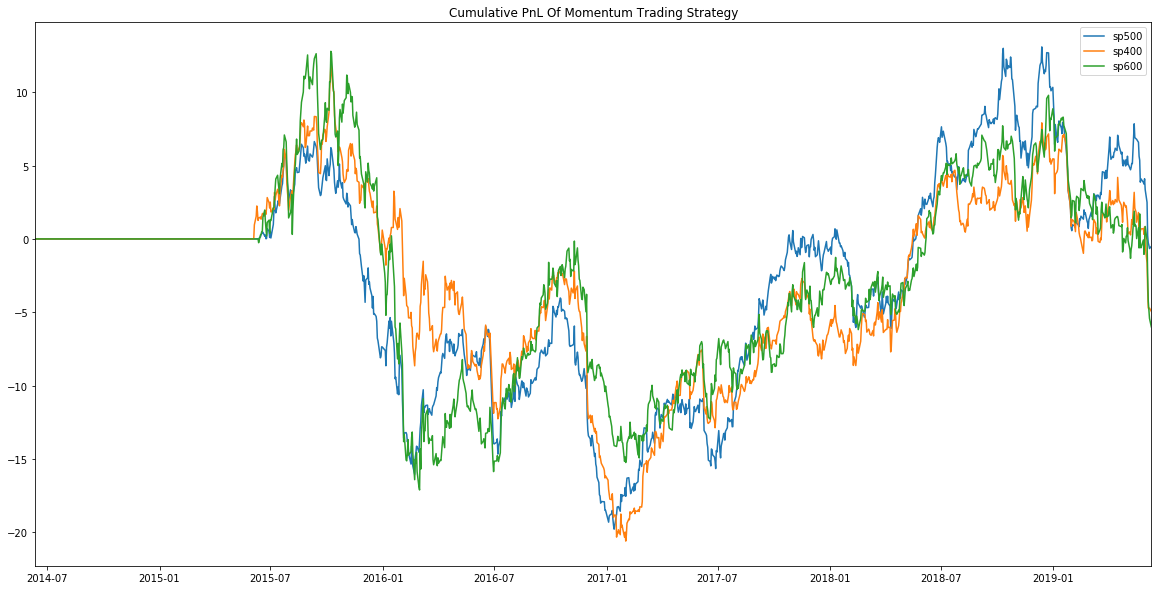

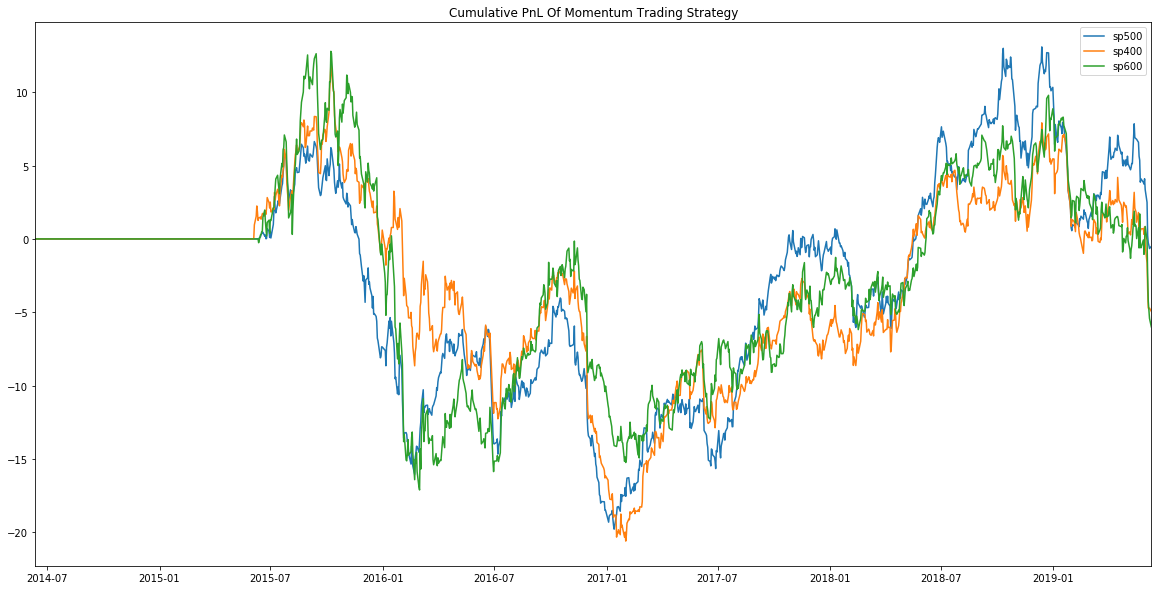

In [32]:
# Set size 
plt.figure(figsize=(20, 10))

for i in range(len(keys)):
    plt.plot(returns_strat[keys[i]].cumsum())

plt.xlim(returns_strat['sp500'].index[0], returns_strat['sp500'].index[-1])    

# Set title and legend
plt.title('Cumulative PnL Of Momentum Trading Strategy')
plt.legend(keys)

## Conclusion
...**To Do**